In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import pickle
import os

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:",device)

Mounted at /content/drive
Using: cuda


In [ ]:
best_params = {'lstm_units': 64, 'learning_rate': 0.009885647542627366, 'weight_decay': 0.00959695196216962}
print(best_params)
best_lstm_units = best_params['lstm_units']
best_learning_rate = best_params['learning_rate']
best_weight_decay = best_params['weight_decay']

{'lstm_units': 64, 'learning_rate': 0.009885647542627366, 'weight_decay': 0.00959695196216962}


In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, bidirectional = True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        pooled = torch.mean(lstm_out, dim = 1)
        out = self.dropout(pooled)
        out = self.fc(out)
        return self.softmax(out)

In [ ]:
model_dir = "/content/drive/My Drive/ADL Final Project/lstm_final_model"
model_path = os.path.join(model_dir, "bilstm_model.pth")
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")

# Load tokenizer
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
model = BiLSTMClassifier(vocab_size = 20000, embedding_dim = 100, hidden_dim = best_lstm_units, output_dim = 3,  dropout = 0.3).to(device)
model.load_state_dict(torch.load(model_path, map_location = device))
model.to(device)
model.eval()

BiLSTMClassifier(
  (embedding): Embedding(20000, 100)
  (lstm): LSTM(100, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
test_df = pd.read_csv("/content/drive/My Drive/ADL Final Project/yelp_dataset_test.csv")
test_sequences = tokenizer.texts_to_sequences(test_df['review_text'])
test_padded = pad_sequences(test_sequences, maxlen = 512, padding = 'post', truncating = 'post')

X_test_tensor = torch.tensor(test_padded, dtype = torch.long)
y_test_tensor = torch.tensor(test_df['class_index'].values, dtype = torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

Test Accuracy: 0.8688
Test F1 Score: 0.8676
Test Precision: 0.8688
Test Recall: 0.8688


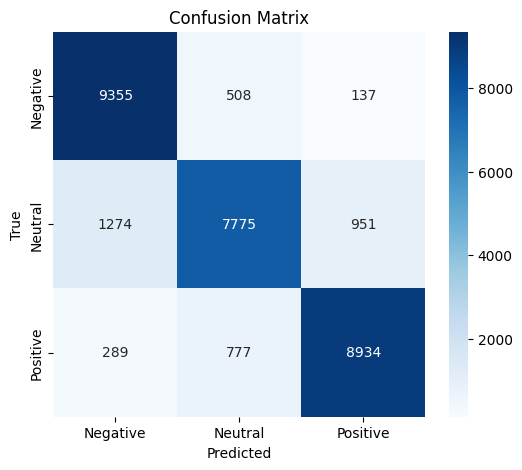

In [ ]:
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim = 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average = 'weighted')
precision = precision_score(all_targets, all_preds, average = 'weighted')
recall = recall_score(all_targets, all_preds, average = 'weighted')
cm = confusion_matrix(all_targets, all_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

# Plot confusion matrix
plt.figure(figsize = (6, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Negative', 'Neutral', 'Positive'], yticklabels = ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Tes